## Importing the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Setting the constants

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=10
channels=3
epochs = 100

## Importing data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
'rice_leaf_diseases',
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)

Found 120 files belonging to 3 classes.


In [4]:
#class names
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
#total batches
len(dataset)

12

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(10, 256, 256, 3)
[1 2 0 0 2 2 0 0 2 1]


## Data visualization

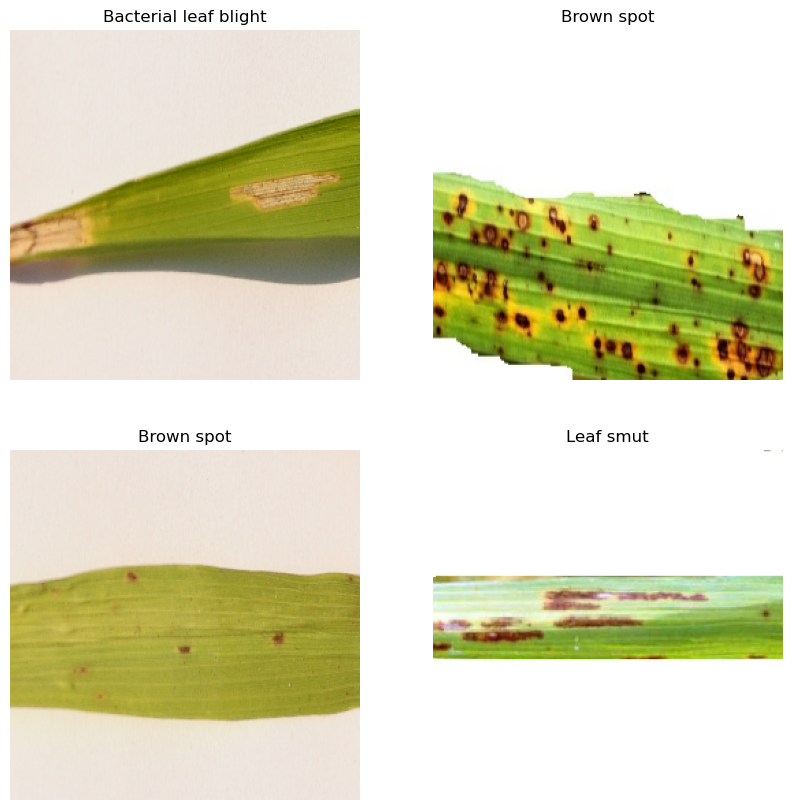

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

## Creating function to split the data for training, testing and validation.

In [8]:
def get_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = 8
    val_size = 2
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds = get_partition_tf(dataset)

In [10]:
len(test_ds)

2

## Chache, shuffle and prefetch the dataset

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating a Layer for Resizing and Normalization

In [12]:
#preprocessing
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras  # Import keras properly


resize_and_rescale = keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])


# Data Augmentation

In [13]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [14]:
# Applying Data Augmentation on train dataset

train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



# Model Architecture

In [15]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Dropout

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    
    # First Conv Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    Dropout(0.2),
    
    # Second Conv Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    Dropout(0.3),
    
    # Third Conv Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    Dropout(0.4),
    
    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [16]:
#architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (10, 256, 256, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (10, 256, 256, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (10, 256, 256, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (10, 256, 256, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (10, 128, 128, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (10, 128, 128, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (10, 128, 128, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (10, 128, 128, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (10, 128, 128, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (10, 128, 128, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (10, 64, 64, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (10, 64, 64, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (10, 64, 64, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (10, 64, 64, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (10, 64, 64, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (10, 64, 64, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,067,043 (65.11 MB)

 Trainable params: 17,065,891 (65.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

## Compiling the Model
* We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric.

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [18]:
history = model.fit(train_ds,epochs=epochs,batch_size=BATCH_SIZE,verbose=1,
         validation_data=val_ds)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.3883 - loss: 2.1368 - val_accuracy: 0.4000 - val_loss: 2.7513
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5848 - loss: 1.0680 - val_accuracy: 0.4000 - val_loss: 8.6940
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6313 - loss: 0.9772 - val_accuracy: 0.4000 - val_loss: 11.8831
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7002 - loss: 0.7005 - val_accuracy: 0.4000 - val_loss: 4.8653
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6619 - loss: 0.8091 - val_accuracy: 0.3500 - val_loss: 4.0063
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7126 - loss: 0.8899 - val_accuracy: 0.4000 - val_loss: 2.6831
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7160 - loss: 0.7576 - val_accuracy: 0.3500 - val_loss: 1.2663
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6184 - loss: 0.7185 - val_accuracy: 0.4000 - val_loss: 1.2573

In [19]:
score = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step - accuracy: 0.9333 - loss: 0.0815


In [29]:
test_loss, test_accuracy = model.evaluate(test_ds)  # Replace with your test dataset
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step - accuracy: 0.9333 - loss: 0.0815
Test Accuracy: 95.00%


In [30]:
score

[0.06685683131217957, 0.949999988079071]

## Plotting the Accuracy and Loss Curves

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 8}

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

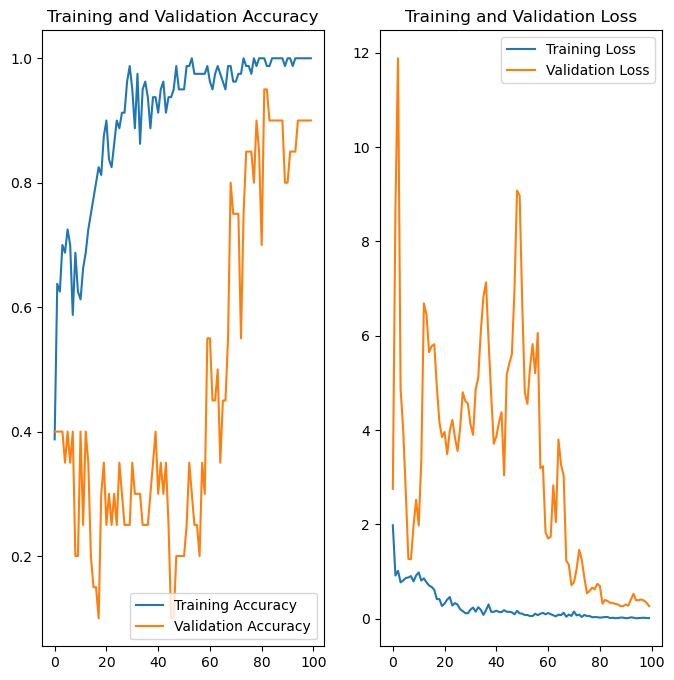

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label: Brown spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
predicted label: Brown spot


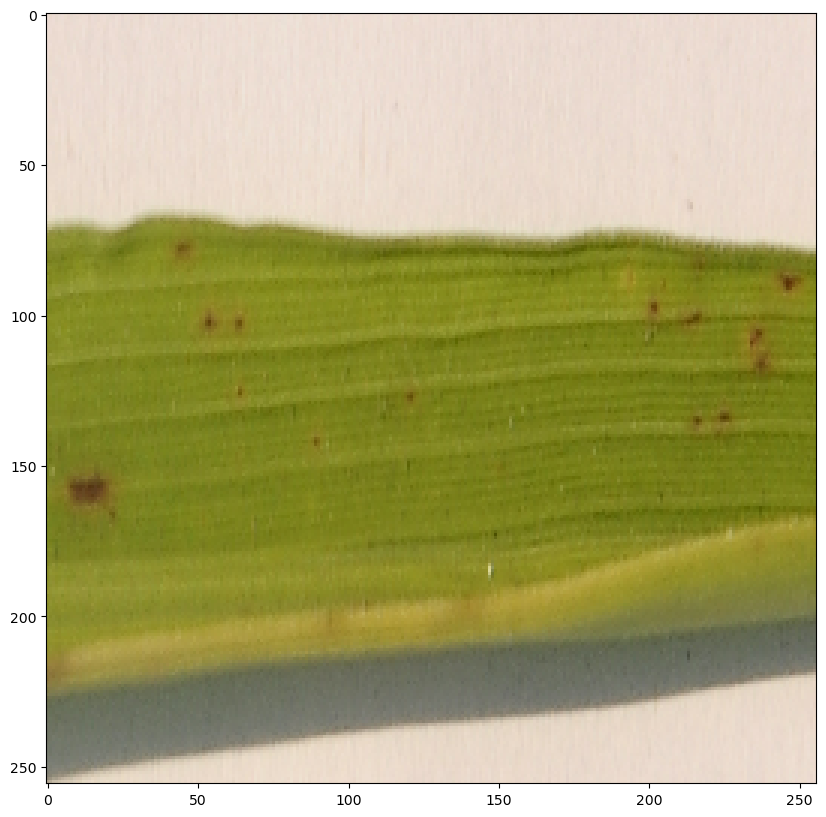

In [35]:
#prediction on sample
plt.figure(figsize=(10,10))
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Creating a function for inference

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Prediction on few Sample Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


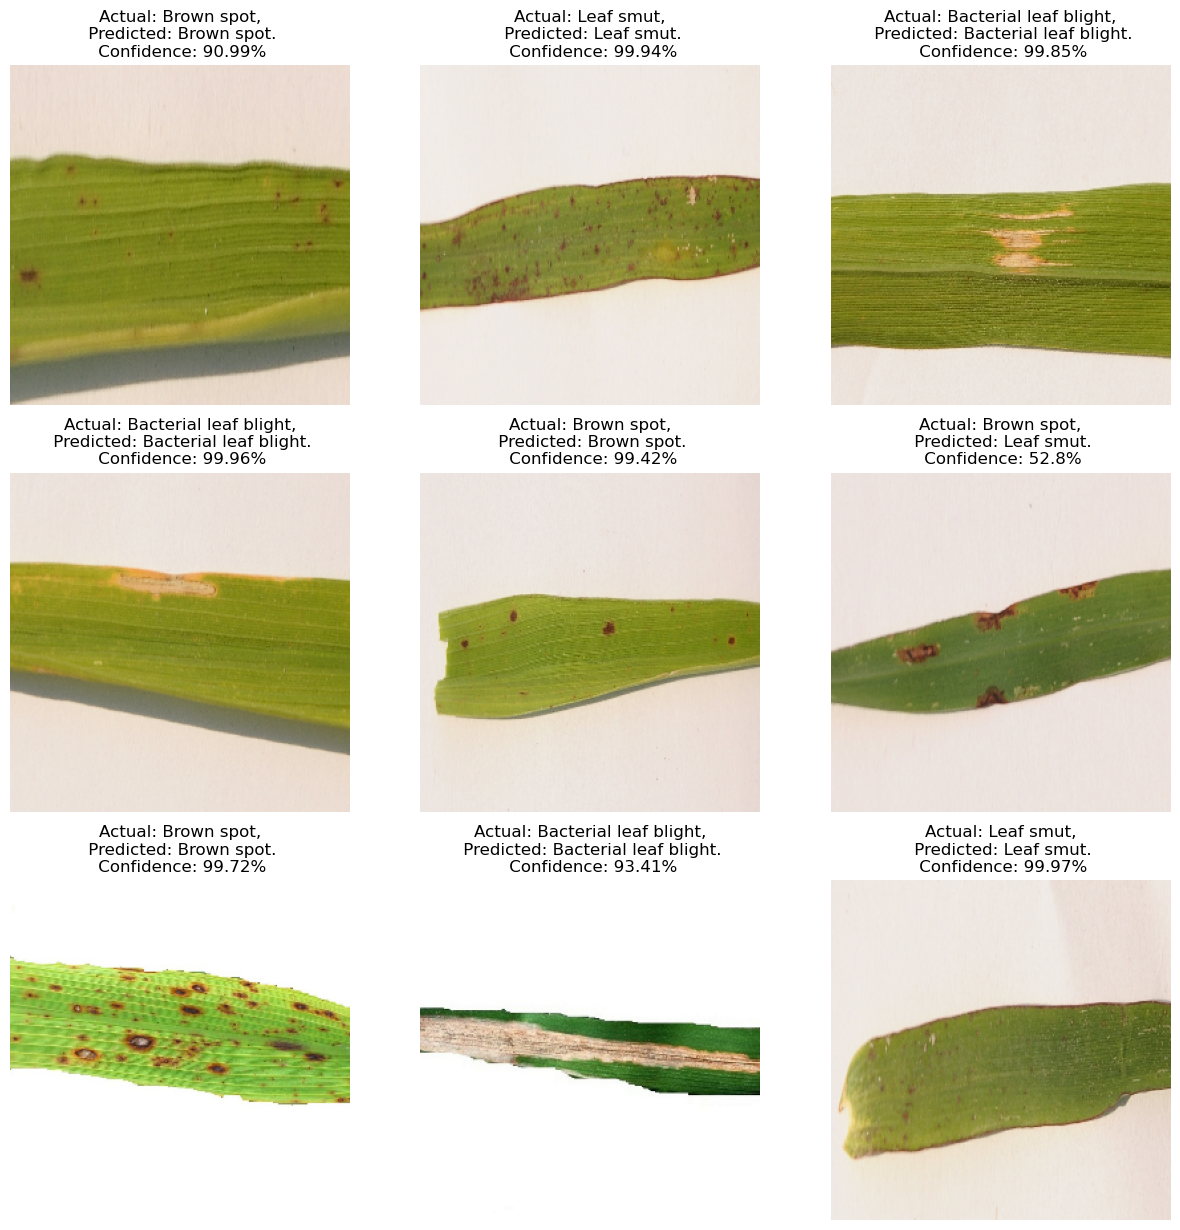

In [37]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions and labels in the correct order
y_true = []
y_pred_probs = []  # Store raw probabilities for potential threshold adjustment

# Process the test dataset without shuffling
for images, labels in test_ds.unbatch():
    y_true.append(labels.numpy())
    y_pred_probs.append(model.predict(images[np.newaxis, ...], verbose=0)[0])

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions

# Calculate accuracy (should match model.evaluate())
accuracy = np.mean(y_true == y_pred)
print(f"\nAccuracy: {accuracy:.4f}")




Accuracy: 0.9500


In [47]:
# Get classification report (includes precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))




Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00         6
           Brown spot       1.00      0.89      0.94         9
            Leaf smut       0.83      1.00      0.91         5

             accuracy                           0.95        20
            macro avg       0.94      0.96      0.95        20
         weighted avg       0.96      0.95      0.95        20




Confusion Matrix:
[[6 0 0]
 [0 8 1]
 [0 0 5]]


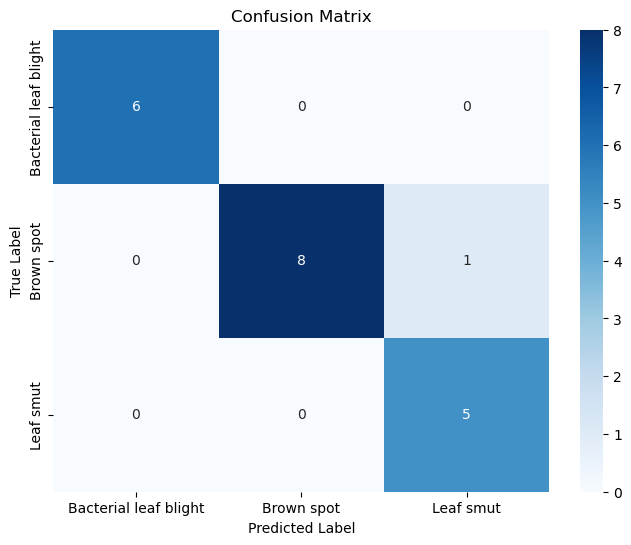

In [48]:
# Calculate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [50]:
# Verify with model.evaluate()
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"\nmodel.evaluate() Accuracy: {test_accuracy:.4f}")

# Calculate per-class metrics manually if needed
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1 = 2 * (precision * recall) / (precision + recall)

print("\nPer-class Precision:", [f"{x:.4f}" for x in precision])
print("Per-class Recall:", [f"{x:.4f}" for x in recall])
print("Per-class F1-score:", [f"{x:.4f}" for x in f1])


model.evaluate() Accuracy: 0.9500

Per-class Precision: ['1.0000', '1.0000', '0.8333']
Per-class Recall: ['1.0000', '0.8889', '1.0000']
Per-class F1-score: ['1.0000', '0.9412', '0.9091']
